In [9]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Check the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Found {num_gpus} CUDA device(s).")

    # Print information about each available GPU
    for i in range(num_gpus):
        device = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {device}")
else:
    print("CUDA (GPU) support is not available.")


Found 1 CUDA device(s).
GPU 0: NVIDIA GeForce RTX 2060


In [6]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import timm

In [7]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C) -> (H, W, 1) -> (H, W) #numpy

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze()

In [8]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))


In [9]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

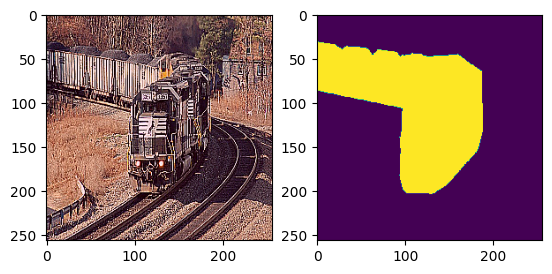

In [10]:

train_dataset = PascalVOCSearchDataset(image_set="train", download=False, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=False, transform=test_trainsform)

image, mask = train_dataset.__getitem__(10)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()

In [11]:
backbone = timm.create_model("efficientnet_b0",pretrained=True,features_only=True)
x = torch.rand(5,3,256,256)
features = backbone(x)
for feature in features:
  print(feature.shape)

torch.Size([5, 16, 128, 128])
torch.Size([5, 24, 64, 64])
torch.Size([5, 40, 32, 32])
torch.Size([5, 112, 16, 16])
torch.Size([5, 320, 8, 8])


In [22]:
def unet_block(in_channels,out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,3,1,1),
      nn.ReLU(),
      nn.Conv2d(out_channels,out_channels,3,1,1),
      nn.ReLU(),
  )


class Unet(nn.Module):
  def __init__(self, n_classes):
      super().__init__()
      self.n_classes = n_classes
      self.backbone = timm.create_model("efficientnet_b0",pretrained=True,features_only=True)
      self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
      self.block_neck = unet_block(320,112)
      self.block_up1 = unet_block(112+112,40)
      self.block_up2 = unet_block(40+40,24)
      self.block_up3 = unet_block(24+24,16)
      self.block_up4 = unet_block(16+16,16)
      self.conv_cls = nn.Conv2d(16,self.n_classes,1)

  def forward(self,x):
    x1,x2,x3,x4,x5 = self.backbone(x)
    x = self.block_neck(x5)
    x = torch.cat([self.upsample(x),x4], dim=1)
    x = self.block_up1(x)

    x = torch.cat([self.upsample(x),x3], dim=1)
    x = self.block_up2(x)

    x = torch.cat([self.upsample(x),x2], dim=1)
    x = self.block_up3(x)

    x = torch.cat([self.upsample(x),x1], dim=1)
    x = self.block_up4(x)
    x = self.conv_cls(x)
    x = self.upsample(x)
    return x

In [13]:
model2 = Unet(21)
x = torch.rand(2,3,128,128)
y = model2(x)
y.shape

torch.Size([2, 21, 128, 128])

In [17]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [18]:
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model
model = Unet(21).to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
n_eps = 70

#metrics
dice_fn = torchmetrics.Dice(num_classes=21, average="macro").to(device)
iou_fn = torchmetrics.JaccardIndex(num_classes=21, task="multiclass", average="macro").to(device)

#meter
acc_meter = AverageMeter()
train_loss_meter = AverageMeter()
dice_meter = AverageMeter()
iou_meter = AverageMeter()

cuda
num_workers = 12


In [19]:
#accuracy fn
def accuracy_function(preds, targets):
    preds_flat = preds.flatten()
    targets_flat = targets.flatten()
    acc = torch.sum(preds_flat == targets_flat)
    return acc/targets_flat.shape[0]

In [26]:
best_dice_score = 0.0  # Initialize with a low value or as appropriate for your metric

for ep in range(1, 1 + n_eps):
    acc_meter.reset()
    train_loss_meter.reset()
    dice_meter.reset()
    iou_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device).long()
        y_hat = model(x)  # (B, C, H, W)
        loss = criterion(y_hat, y)  # (B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            y_hat_mask = y_hat.argmax(dim=1).squeeze()  # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            dice_score = dice_fn(y_hat_mask, y.long())
            iou_score = iou_fn(y_hat_mask, y.long())
            accuracy = accuracy_function(y_hat_mask, y.long())

            train_loss_meter.update(loss.item(), n)
            iou_meter.update(iou_score.item(), n)
            dice_meter.update(dice_score.item(), n)
            acc_meter.update(accuracy.item(), n)

    print("EP {}, train loss = {}, accuracy = {}, IoU = {}, dice = {}".format(
        ep, train_loss_meter.avg, acc_meter.avg, iou_meter.avg, dice_meter.avg
    ))

    # Save the model if the current dice score is better than the best seen so far
    if dice_meter.avg > best_dice_score:
        best_dice_score = dice_meter.avg
        torch.save(model.state_dict(), "best_modelUNet.pth")

    if ep >= 70:
        torch.save(model.state_dict(), "modelUNet_ep_{}.pth".format(ep))


  0%|          | 0/92 [00:00<?, ?it/s]

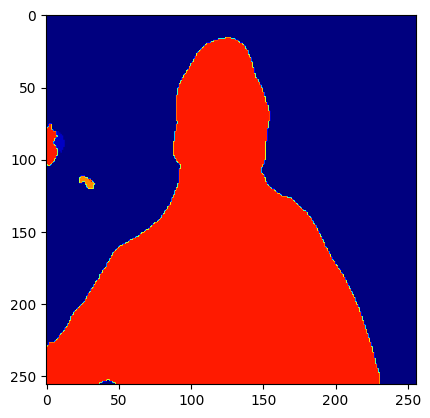

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the pre-trained U-Net model
model = Unet(n_classes=21)  # Create an instance of your U-Net model class
model.load_state_dict(torch.load("modelUNet_ep_70.pth", map_location=torch.device('cpu')))  # Use 'cuda' if available
model.eval()

# Load and preprocess the input image
image = Image.open("2007_000170.jpg")  # Replace with the path to your image
transform = transforms.Compose([transforms.Resize((256, 256)),  # Resize to match the model's input size
                               transforms.ToTensor(),  # Convert to a PyTorch tensor
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Normalize as needed
input_tensor = transform(image).unsqueeze(0)  # Add a batch dimension

# Move the model and input tensor to the same device (CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
input_tensor = input_tensor.to(device)

# Perform inference with the U-Net model
with torch.no_grad():
    output = model(input_tensor)

# Post-process and visualize the output
output = output.cpu().numpy()  # Move to CPU and convert to NumPy array
segmentation_mask = np.argmax(output, axis=1)  # If your model outputs class probabilities, use argmax to get the class with the highest probability

plt.imshow(segmentation_mask[0], cmap='jet')  # Adjust colormap as needed
plt.show()
